In [1]:
!pip install tensorflow -q

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [3]:
# -----------------------------
# 1) Load data
# -----------------------------
CSV_PATH = "spotify_data clean.csv"   # sesuaikan path
df = pd.read_csv(CSV_PATH)
assert "track_popularity" in df.columns, "Kolom 'track_popularity' tidak ditemukan!"

# -----------------------------
# 2) Feature engineering (ringkas & jelas)
# -----------------------------
# Ambil tahun dari album_release_date -> album_year
def to_year(x):
    try:
        y = int(str(x)[:4])
        return y if 1800 <= y <= 2100 else np.nan
    except:
        return np.nan

df["album_year"] = df["album_release_date"].apply(to_year)

# Fitur numerik
num_cols = [
    "track_number",
    "track_duration_min",   # versi clean sudah menit
    "artist_popularity",
    "artist_followers",
    "album_total_tracks",
    "album_year",
]

# Coerce numerik + isi NA dengan median
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Biner untuk explicit
if "explicit" in df.columns:
    df["explicit_bin"] = df["explicit"].astype(str).str.lower().isin(["true","1","yes"]).astype(int)
else:
    df["explicit_bin"] = 0

# Kategori untuk embedding
for c in ["artist_name", "album_type"]:
    if c not in df.columns:
        df[c] = "UNK"
df["artist_name"] = df["artist_name"].astype(str).fillna("UNK")
df["album_type"]  = df["album_type"].astype(str).fillna("unknown")

# Buat kamus id (integer) untuk kategori
artist_vocab = sorted(df["artist_name"].unique().tolist())
albumtype_vocab = sorted(df["album_type"].unique().tolist())
artist_to_id = {name:i for i, name in enumerate(artist_vocab)}
album_to_id  = {name:i for i, name in enumerate(albumtype_vocab)}

df["artist_id"]    = df["artist_name"].map(artist_to_id).astype(int)
df["albumtype_id"] = df["album_type"].map(album_to_id).astype(int)

# Target
y = df["track_popularity"].astype(float).values

# Kumpulan fitur akhir
feature_cols_numeric = num_cols + ["explicit_bin"]
X_num = df[feature_cols_numeric].copy().values
X_artist = df["artist_id"].values
X_album = df["albumtype_id"].values

# -----------------------------
# 3) Split data: 70/10/20
# -----------------------------
X_num_train, X_num_temp, art_train, art_temp, alb_train, alb_temp, y_train, y_temp = train_test_split(
    X_num, X_artist, X_album, y, test_size=0.30, random_state=42
)
X_num_val, X_num_test, art_val, art_test, alb_val, alb_test, y_val, y_test = train_test_split(
    X_num_temp, art_temp, alb_temp, y_temp, test_size=(2/3), random_state=42
)

print(f"Train  : {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}")

# -----------------------------
# 4) Scale fitur numerik
# -----------------------------
scaler = StandardScaler()
X_num_train_s = scaler.fit_transform(X_num_train)
X_num_val_s   = scaler.transform(X_num_val)
X_num_test_s  = scaler.transform(X_num_test)

# (Opsional) simpan scaler
joblib.dump(scaler, "num_scaler.pkl")


Train  : 6007 | Val: 858 | Test: 1717


['num_scaler.pkl']

In [4]:
# -----------------------------
# 5) Bangun model DL (Keras)
# -----------------------------
n_artists    = len(artist_vocab)
n_albumtypes = len(albumtype_vocab)

# Heuristik dimensi embedding (kecil tapi efektif)
artist_emb_dim = int(np.clip(np.sqrt(max(n_artists, 2)), 8, 32))
album_emb_dim  = int(np.clip(np.sqrt(max(n_albumtypes, 2)), 4, 16))

inp_artist = Input(shape=(1,), name="artist_id_in")
inp_album  = Input(shape=(1,), name="albumtype_id_in")
inp_num    = Input(shape=(X_num_train_s.shape[1],), name="num_in")

emb_artist = Embedding(input_dim=n_artists, output_dim=artist_emb_dim, name="artist_emb")(inp_artist)
emb_album  = Embedding(input_dim=n_albumtypes, output_dim=album_emb_dim, name="album_emb")(inp_album)
vec_artist = Flatten()(emb_artist)
vec_album  = Flatten()(emb_album)

x = Concatenate(name="concat")([vec_artist, vec_album, inp_num])
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
out = Dense(1, name="popularity")(x)   # regresi

model = Model(inputs=[inp_artist, inp_album, inp_num], outputs=out)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ artist_id_in        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ albumtype_id_in     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ artist_emb          │ (None, 1, 32)     │     81,536 │ artist_id_in[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ album_emb           │ (None, 1, 4)      │         12 │ albumtype_id_in[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ artist_emb[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4)         │          0 │ album_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 43)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      5,632 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ popularity (Dense)  │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,501 (373.05 KB)

 Trainable params: 95,501 (373.05 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# -----------------------------
# 6) Train dengan callback
# -----------------------------
ckpt_path = "best_model.keras"
callbacks = [
    EarlyStopping(monitor="val_mae", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=3, verbose=1, min_lr=1e-5),
    ModelCheckpoint(ckpt_path, monitor="val_mae", save_best_only=True)
]

history = model.fit(
    x={"artist_id_in": art_train, "albumtype_id_in": alb_train, "num_in": X_num_train_s},
    y=y_train,
    validation_data=(
        {"artist_id_in": art_val, "albumtype_id_in": alb_val, "num_in": X_num_val_s},
        y_val
    ),
    epochs=40,           # cukup singkat karena ada early stopping
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 3228.6538 - mae: 51.7389 - val_loss: 3007.0454 - val_mae: 49.5448 - learning_rate: 0.0010
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2767.2339 - mae: 47.6526 - val_loss: 1987.7750 - val_mae: 40.0284 - learning_rate: 0.0010
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1509.4504 - mae: 34.5812 - val_loss: 542.0216 - val_mae: 19.0147 - learning_rate: 0.0010
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 536.5591 - mae: 18.2918 - val_loss: 454.9446 - val_mae: 17.1182 - learning_rate: 0.0010
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 431.5423 - mae: 16.2746 - val_loss: 417.3291 - val_mae: 15.8972 - learning_rate: 0.0010
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 393.4981 - mae: 15.0987 - val_loss: 403.6553 - val_mae: 15.4588 - learning_rate: 0.0010
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 353.6918 - mae: 14.2434 - val_loss: 397.8797 - val_ma

In [6]:
# -----------------------------
# 7) Evaluasi di TEST
# -----------------------------
test_loss, test_mae = model.evaluate(
    {"artist_id_in": art_test, "albumtype_id_in": alb_test, "num_in": X_num_test_s},
    y_test,
    verbose=0
)
print(f"[TEST] MSE={test_loss:.4f} | MAE={test_mae:.4f}")

# Contoh prediksi 10 sampel
preds = model.predict(
    {"artist_id_in": art_test[:10], "albumtype_id_in": alb_test[:10], "num_in": X_num_test_s[:10]},
    verbose=0
).flatten()
print("\nPreview y_true vs y_pred (10 sampel):")
print(np.vstack([y_test[:10], np.round(preds, 2)]).T)

[TEST] MSE=429.2157 | MAE=15.3905

Preview y_true vs y_pred (10 sampel):
[[40.         32.56999969]
 [57.         53.06000137]
 [73.         71.        ]
 [40.         52.06000137]
 [58.         42.18000031]
 [59.         57.54000092]
 [48.         30.37999916]
 [67.         19.21999931]
 [81.         69.51000214]
 [43.         46.04999924]]


In [8]:
# === setelah split (punya: df, y, X_num_train, ... dan juga index asli jika perlu) ===
# Kita butuh kolom 'artist_name' & 'album_release_date' di dataframe split.
# Ambil baris TRAIN/VAL/TEST dari df asli pakai mask indeks (sesuaikan kalau kamu simpan index):
train_mask = np.zeros(len(df), dtype=bool); train_mask[:len(X_num_train)] = True  # <-- sesuaikan cara bikin mask milikmu
# kalau kamu tidak simpan index, paling aman: buat df_train/val/test sebelum transform numerik

# Cara yang lebih eksplisit (direkomendasikan):
df_feats = df[["artist_name","album_release_date"]].copy()
df_feats["album_year"] = df["album_year"]  # sudah dihitung sebelumnya
df_feats["track_popularity"] = df["track_popularity"].astype(float)

# Bagi df_feats sesuai split sebelumnya
df_train_feats = df_feats.iloc[:len(X_num_train)].copy()
df_val_feats   = df_feats.iloc[len(X_num_train):len(X_num_train)+len(X_num_val)].copy()
df_test_feats  = df_feats.iloc[len(X_num_train)+len(X_num_val):len(X_num_train)+len(X_num_val)+len(X_num_test)].copy()

# --- Fitur 1: rata-rata popularitas artis (TRAIN-only)
artist_mean_train = df_train_feats.groupby("artist_name")["track_popularity"].mean().to_dict()
global_mean = df_train_feats["track_popularity"].mean()

def map_artist_mean(s):
    return s.map(artist_mean_train).fillna(global_mean)

artist_avg_pop_train = map_artist_mean(df_train_feats["artist_name"])
artist_avg_pop_val   = map_artist_mean(df_val_feats["artist_name"])
artist_avg_pop_test  = map_artist_mean(df_test_feats["artist_name"])

# --- Fitur 2: track_age (semakin baru biasanya lebih populer)
CURRENT_YEAR = 2025
track_age_train = (CURRENT_YEAR - df_train_feats["album_year"].fillna(CURRENT_YEAR)).clip(lower=0)
track_age_val   = (CURRENT_YEAR - df_val_feats["album_year"].fillna(CURRENT_YEAR)).clip(lower=0)
track_age_test  = (CURRENT_YEAR - df_test_feats["album_year"].fillna(CURRENT_YEAR)).clip(lower=0)

# --- Fitur 3: banyaknya lagu artis di TRAIN (proxy reputasi/eksposur)
artist_count_train_map = df_train_feats["artist_name"].value_counts().to_dict()
def map_artist_count(s):
    return s.map(artist_count_train_map).fillna(1)

artist_count_train = map_artist_count(df_train_feats["artist_name"])
artist_count_val   = map_artist_count(df_val_feats["artist_name"])
artist_count_test  = map_artist_count(df_test_feats["artist_name"])

# Gabung ke matriks numerik (urutan sama dengan split num)
X_num_train = np.column_stack([X_num_train,
                               artist_avg_pop_train.values,
                               track_age_train.values,
                               artist_count_train.values])
X_num_val   = np.column_stack([X_num_val,
                               artist_avg_pop_val.values,
                               track_age_val.values,
                               artist_count_val.values])
X_num_test  = np.column_stack([X_num_test,
                               artist_avg_pop_test.values,
                               track_age_test.values,
                               artist_count_test.values])

# Update daftar kolom numerik (kalau kamu simpan)
# feature_cols_numeric += ["artist_avg_popularity", "track_age", "artist_track_count"]


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_train_s = scaler.fit_transform(X_num_train)
X_num_val_s   = scaler.transform(X_num_val)
X_num_test_s  = scaler.transform(X_num_test)


In [10]:
# scale target
y_train_s = y_train / 100.0
y_val_s   = y_val   / 100.0
y_test_s  = y_test  / 100.0


In [11]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model

n_artists, n_albumtypes = len(artist_vocab), len(albumtype_vocab)
artist_emb_dim = int(np.clip(np.sqrt(max(n_artists, 2)), 8, 32))
album_emb_dim  = int(np.clip(np.sqrt(max(n_albumtypes, 2)), 4, 16))

inp_artist = Input(shape=(1,), name="artist_id_in")
inp_album  = Input(shape=(1,), name="albumtype_id_in")
inp_num    = Input(shape=(X_num_train_s.shape[1],), name="num_in")

emb_artist = Embedding(n_artists, artist_emb_dim, name="artist_emb")(inp_artist)
emb_album  = Embedding(n_albumtypes, album_emb_dim, name="album_emb")(inp_album)
vec_artist = Flatten()(emb_artist)
vec_album  = Flatten()(emb_album)

x = Concatenate(name="concat")([vec_artist, vec_album, inp_num])
x = BatchNormalization()(x)
x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.25)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.25)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
# output sigmoid (0..1)
out = Dense(1, activation="sigmoid", name="popularity")(x)

model = Model(inputs=[inp_artist, inp_album, inp_num], outputs=out)

opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ artist_id_in        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ albumtype_id_in     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ artist_emb          │ (None, 1, 32)     │     81,536 │ artist_id_in[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ album_emb           │ (None, 1, 4)      │         12 │ albumtype_id_in[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ artist_emb[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4)         │          0 │ album_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 10)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 46)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 46)        │        184 │ concat[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     12,032 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ popularity (Dense)  │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,981 (527.27 KB)

 Trainable params: 134,889 (526.91 KB)

 Non-trainable params: 92 (368.00 B)

In [12]:
ckpt_path = "best_model.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=4, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_mae", save_best_only=True)
]

history = model.fit(
    x={"artist_id_in": art_train, "albumtype_id_in": alb_train, "num_in": X_num_train_s},
    y=y_train_s,  # <== pakai target skala 0..1
    validation_data=(
        {"artist_id_in": art_val, "albumtype_id_in": alb_val, "num_in": X_num_val_s},
        y_val_s
    ),
    epochs=60,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0599 - mae: 0.1932 - val_loss: 0.0523 - val_mae: 0.1767 - learning_rate: 3.0000e-04
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0506 - mae: 0.1705 - val_loss: 0.0480 - val_mae: 0.1622 - learning_rate: 3.0000e-04
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0459 - mae: 0.1563 - val_loss: 0.0462 - val_mae: 0.1612 - learning_rate: 3.0000e-04
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0441 - mae: 0.1524 - val_loss: 0.0454 - val_mae: 0.1572 - learning_rate: 3.0000e-04
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0424 - mae: 0.1471 - val_loss: 0.0453 - val_mae: 0.1579 - learning_rate: 3.0000e-04
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0394 - mae: 0.1410 - val_loss: 0.0448 - val_mae: 0.1552 - learning_rate: 3.0000e-04
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0361 - mae: 0.1341 - val_loss: 0.0447 - val_mae: 0.1562 - learning_r

In [13]:
# evaluasi
test_loss, test_mae = model.evaluate(
    {"artist_id_in": art_test, "albumtype_id_in": alb_test, "num_in": X_num_test_s},
    y_test_s,
    verbose=0
)
# convert metrik ke skala 0..100
print(f"[TEST] MSE={test_loss * (100**2):.4f} | MAE={test_mae * 100:.4f}")

# prediksi 10 sampel
preds_s = model.predict(
    {"artist_id_in": art_test[:10], "albumtype_id_in": alb_test[:10], "num_in": X_num_test_s[:10]},
    verbose=0
).flatten()
preds = np.clip(preds_s * 100.0, 0, 100)
print("\nPreview y_true vs y_pred (10 sampel):")
print(np.vstack([y_test[:10], np.round(preds, 2)]).T)


[TEST] MSE=488.3245 | MAE=15.0121

Preview y_true vs y_pred (10 sampel):
[[40.         22.32999992]
 [57.         59.88000107]
 [73.         66.19000244]
 [40.         56.38000107]
 [58.         57.72000122]
 [59.         64.54000092]
 [48.         40.15999985]
 [67.         34.13999939]
 [81.         63.02000046]
 [43.         56.56999969]]


Hasil Evaluasi Model pada Data Test:


,Model,MAE (Test),MSE (Test)
0,Model 1 (Original),15.3905,429.2157
1,Model 2 (Improved),15.0121,488.3245


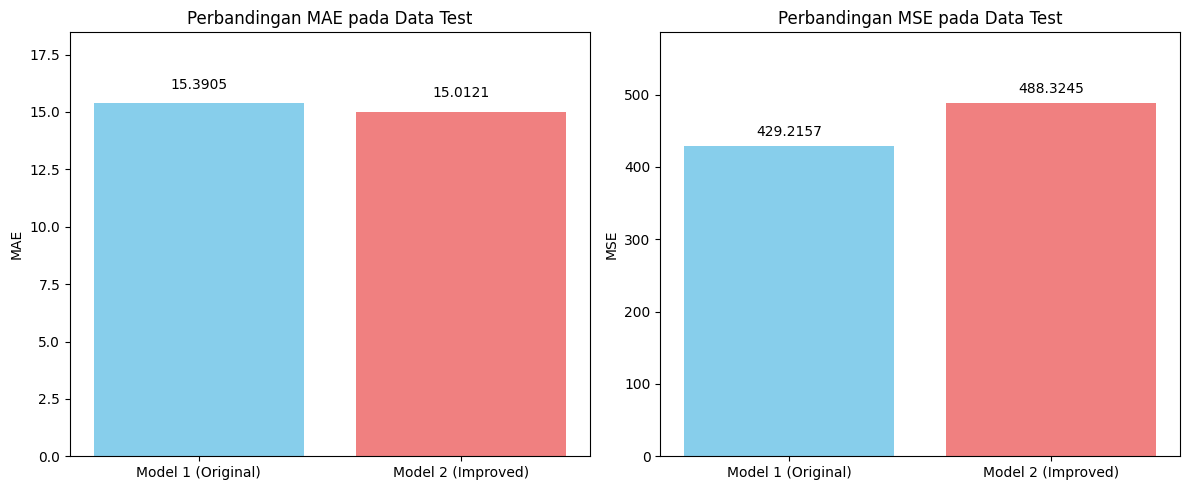

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asumsikan hasil evaluasi model pertama (tanpa scaling target, tanpa batchnorm/reg)
# Test MAE dan MSE dari cell GxXs2m1O_siL
test_loss_model1 = 429.2157 # Ini sebenarnya MSE
test_mae_model1 = 15.3905   # Ini MAE


# Asumsikan hasil evaluasi model kedua (dengan scaling target, batchnorm, reg)
# Test MAE dan MSE dari cell cvI4lPGURqS6 (sudah diskalakan kembali ke 0-100)
test_loss_model2 = 488.3245 # Ini MSE
test_mae_model2 = 15.0121   # Ini MAE

# Buat DataFrame untuk menyimpan hasil
data = {'Model': ['Model 1 (Original)', 'Model 2 (Improved)'],
        'MAE (Test)': [test_mae_model1, test_mae_model2],
        'MSE (Test)': [test_loss_model1, test_loss_model2]}
df_results = pd.DataFrame(data)

print("Hasil Evaluasi Model pada Data Test:")
display(df_results)

# Buat grafik batang untuk perbandingan MAE dan MSE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Grafik MAE
axes[0].bar(df_results['Model'], df_results['MAE (Test)'], color=['skyblue', 'lightcoral'])
axes[0].set_ylabel('MAE')
axes[0].set_title('Perbandingan MAE pada Data Test')
axes[0].set_ylim(0, max(df_results['MAE (Test)']) * 1.2) # Atur limit y
for i, v in enumerate(df_results['MAE (Test)']):
    axes[0].text(i, v + 0.5, f"{v:.4f}", ha='center', va='bottom')


# Grafik MSE
axes[1].bar(df_results['Model'], df_results['MSE (Test)'], color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('MSE')
axes[1].set_title('Perbandingan MSE pada Data Test')
axes[1].set_ylim(0, max(df_results['MSE (Test)']) * 1.2) # Atur limit y
for i, v in enumerate(df_results['MSE (Test)']):
     axes[1].text(i, v + 10, f"{v:.4f}", ha='center', va='bottom')


plt.tight_layout()
plt.show()

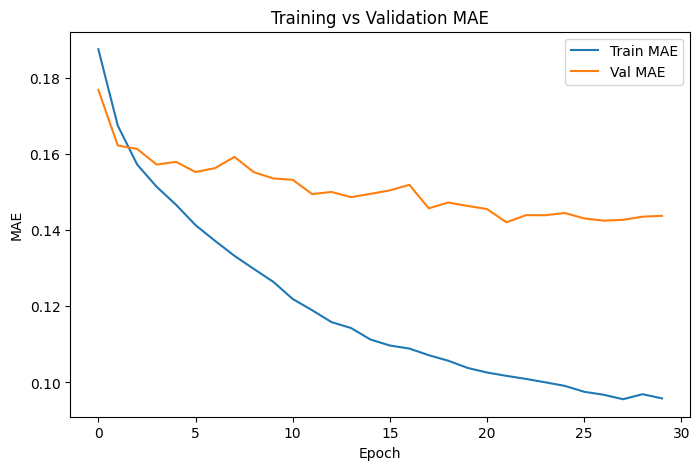

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.show()


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(
    {"artist_id_in": art_test, "albumtype_id_in": alb_test, "num_in": X_num_test_s},
    verbose=0
).flatten() * 100
residuals = y_test - y_pred

df_resid = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'residual': residuals,
    'artist': df_test_feats['artist_name']
})

# Artis atau lagu dengan error terbesar
df_resid['abs_err'] = df_resid['residual'].abs()
print(df_resid.sort_values('abs_err', ascending=False).head(10))


      y_true     y_pred   residual                artist    abs_err
8579     2.0  82.950066 -80.950066           The Mystics  80.950066
8517     1.0  81.384613 -80.384613   Derek & The Dominos  80.384613
8552     0.0  79.607422 -79.607422       Ennio Morricone  79.607422
8032     1.0  78.744873 -77.744873          Busta Rhymes  77.744873
8364     4.0  80.220367 -76.220367         Pet Shop Boys  76.220367
7676     0.0  74.802750 -74.802750         Thomas Newman  74.802750
8569     2.0  76.405457 -74.405457             Link Wray  74.405457
7981     3.0  76.896584 -73.896584           Smash Mouth  73.896584
7615     0.0  72.750992 -72.750992  The Notorious B.I.G.  72.750992
7962     1.0  73.602036 -72.602036              Le Tigre  72.602036


In [15]:
# -----------------------------
# 8) Simpan model akhir (opsional)
# -----------------------------
model.save("final_model.keras")
print("Model tersimpan ke 'final_model.keras' dan checkpoint terbaik di 'best_model.keras'.")

Model tersimpan ke 'final_model.keras' dan checkpoint terbaik di 'best_model.keras'.
